# This is the pytorch implementation of the deep learning model proposed in the paper 'Deep Visible and Thermal Image Fusion for Enhanced pedestrian visibility'

In [1]:
#Import packages
import time
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import numpy as np
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.models.vgg import vgg19
import torch.nn as nn
import torch.nn.functional as F
import torch
from skimage import img_as_ubyte
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # dataset
import matplotlib.pyplot as plt
import scipy
import numpy as np
import argparse
import glob
import imageio
from skimage import color
import numpy
import natsort
import scipy
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import pprint
from scipy.ndimage import correlate
from scipy.ndimage.filters import gaussian_gradient_magnitude
import torchvision.datasets as dset
import torch.utils.data as data
import os
import os.path
from tkinter import *
import tkinter as tk
import tkinter.font as tkFont
from PIL import ImageTk, Image
import pylab
import cv2
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_properties(0).total_memory)

11811160064


In [3]:
import multiprocessing

multiprocessing.cpu_count()

12

In [4]:
#define the hyperparameters
image_length = 256
image_width  = 256
mr_channels  = 1
gray_channels = 1
pet_channels = 4    
rgb_channels = 3     
batch_size   = 1
EPOCH = 100
learning_rate = 0.002 

In [5]:
#load the train mri data
filenames = os.listdir('C:/Users/horan/Desktop/FuseVis/Training/MRI')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/FuseVis/Training/MRI')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
train_mri = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    train_mri[i,:,:] =(imageio.imread(data[i]))
    train_mri[i,:,:] =(train_mri[i,:,:] - np.min(train_mri[i,:,:])) / (np.max(train_mri[i,:,:]) - np.min(train_mri[i,:,:]))
    train_mri[i,:,:] = np.float32(train_mri[i,:,:])

In [6]:
#expand dimension to add the channel
train_mri = np.expand_dims(train_mri,axis=1)

In [7]:
#verify the shape matches the pytorch standard
train_mri.shape

(272, 1, 256, 256)

In [8]:
#convert the MRI training data to pytorch tensor
train_mri_tensor = torch.from_numpy(train_mri).float()
train_mri_tensor.shape

torch.Size([272, 1, 256, 256])

In [9]:
#load the train pet data
filenames = os.listdir('C:/Users/horan/Desktop/FuseVis/Training/PET')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/FuseVis/Training/PET')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
train_other = np.zeros((len(data),image_width,image_length,pet_channels),dtype=float)
train_pet = np.zeros((len(data),image_width,image_length),dtype=float)
for i in range(len(data)):
    train_other[i,:,:,:] =(imageio.imread(data[i]))
    train_pet[i,:,:] = 0.2989 * train_other[i,:,:,0] + 0.5870 *  train_other[i,:,:,1]  + 0.1140 * train_other[i,:,:,2]
    train_pet[i,:,:] =(train_pet[i,:,:] - np.min(train_pet[i,:,:])) / (np.max(train_pet[i,:,:]) - np.min(train_pet[i,:,:]))

In [10]:
#expand the dimension to add the channel
train_pet = np.expand_dims(train_pet,axis=1)

In [11]:
#verify the shape matches the pytorch standard
train_pet.shape

(272, 1, 256, 256)

In [12]:
#convert the PET training data to pytorch tensor
train_pet_tensor = torch.from_numpy(train_pet).float()
train_pet_tensor.shape

torch.Size([272, 1, 256, 256])

In [5]:
#define the fusion network
#define the network
class DeepPedestrian(nn.Module):
    def  __init__(self):
        super(DeepPedestrian, self).__init__()
        #####layer 1#####
        self.conv1 = nn.Sequential(                             #input shape  (,2,256,256)
                         nn.Conv2d(in_channels=2, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1)
                         )                                     #output shape (,48,256,256)   
        #####layer 2#####
        self.conv2 = nn.Sequential(                            #input shape  (,48,256,256)
                         nn.ReLU(),
                         nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1)
                         )                                     #output shape (,48,256,256)   
        #####layer 3#####
        self.conv3 = nn.Sequential(                            #input shape  (,48,256,256)
                         nn.ReLU(), 
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1)
                         )                                     #output shape (,48,256,256)     
        #####layer 4#####
        self.conv4 = nn.Sequential(                            #input shape  (,48,256,256)
                         nn.ReLU(), 
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1)
                         )                                      #output shape (,48,256,256)  
        #####layer 5#####
        self.conv5 = nn.Sequential(                             #input shape (, 48, 256, 256)
                          nn.ReLU(),
                          nn.Conv2d(in_channels  = 48,  out_channels = 1, kernel_size  = 3, stride = 1, padding = 1)) 
                                                                #output shape (,1, 256, 256)
        
    def forward(self, x, y):
        #layer 1
        x1 = self.conv1(torch.cat((x,y),dim=1))
        #layer 2
        x2 = self.conv2(x1)
        #residual layer
        x3 = x1+x2
        #layer 3
        x4 = self.conv3(x3)
        #layer 4
        x5 = self.conv4(x4)
        #residual layer
        x6 = x4 + x5
        #layer 5
        fused = self.conv5(x6)
        return fused
        #execute the network

cnn = DeepPedestrian().to(device)
cnn = cnn.float()
print(cnn)

DeepPedestrian(
  (conv1): Sequential(
    (0): Conv2d(2, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): ReLU()
    (1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv3): Sequential(
    (0): ReLU()
    (1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(

In [14]:
#define the optimizers and loss functions 
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)   # optimize all cnn parameters
l2_loss   = nn.MSELoss() #MSEloss

In [17]:
# perform the training
counter = 0
start_time = time.time()
lamda = 0.8
ep_mri_ssim_loss = []
ep_pet_ssim_loss = []
ep_total_l2_loss = []
for epoch in range(EPOCH):
    mri_ssim_Loss = []
    pet_ssim_Loss = []
    l2_Loss       = []
    #run batch images
    batch_idxs = 272 // batch_size
    for idx in range(0, batch_idxs):
        b_x = train_mri_tensor[idx*batch_size : (idx+1)*batch_size,:,:,:].to(device)
        b_y = train_pet_tensor[idx*batch_size : (idx+1)*batch_size,:,:,:].to(device)
        counter += 1
        output = cnn(b_x, b_y)             # cnn output
        ssim_loss_mri = 1 - ssim(output, b_x,data_range=1)
        ssim_loss_pet = 1 - ssim(output, b_y,data_range=1)
        ssim_total = ssim_loss_mri + ssim_loss_pet
        l2_total = l2_loss(output,b_x) + l2_loss(output,b_y)
        loss_total = lamda*ssim_total + (1-lamda)*l2_total 
        optimizer.zero_grad()              # clear gradients for this training step
        loss_total.backward()              # backpropagation, compute gradients
        optimizer.step()                   # apply gradients
        
        mri_ssim_Loss.append(ssim_loss_mri.item())
        pet_ssim_Loss.append(ssim_loss_pet.item())
        l2_Loss.append(l2_total.item())
        
        if counter % 100 == 0:
            print("Epoch: [%2d],step: [%2d], mri_ssim_loss: [%.8f], pet_ssim_loss: [%.8f],  total_ssim_loss: [%.8f], total_l2_loss: [%.8f], total_loss: [%.8f]" 
                   %(epoch, counter, ssim_loss_mri, ssim_loss_pet, ssim_total, l2_total, loss_total))
    
    av_mri_ssim_loss = np.average(mri_ssim_Loss)
    ep_mri_ssim_loss.append(av_mri_ssim_loss)
    
    av_pet_ssim_loss = np.average(pet_ssim_Loss)
    ep_pet_ssim_loss.append(av_pet_ssim_loss)
    
    av_total_l2_loss = np.average(l2_Loss)
    ep_total_l2_loss.append(av_total_l2_loss)
    
    if(epoch == EPOCH -1):
        #Save a checkpoint
        torch.save(cnn, 'C:/Users/horan/Desktop/FuseVis/.ipynb_checkpoints/DeepPedestrian/checkpoint.pth') 

Epoch: [ 0],step: [100], mri_ssim_loss: [0.27498055], pet_ssim_loss: [0.05964434],  total_ssim_loss: [0.33462489], total_l2_loss: [0.02706867], total_loss: [0.27311367]
Epoch: [ 0],step: [200], mri_ssim_loss: [0.44140923], pet_ssim_loss: [0.16461217],  total_ssim_loss: [0.60602140], total_l2_loss: [0.04328252], total_loss: [0.49347362]
Epoch: [ 1],step: [300], mri_ssim_loss: [0.17709357], pet_ssim_loss: [0.26688582],  total_ssim_loss: [0.44397938], total_l2_loss: [0.01219955], total_loss: [0.35762343]
Epoch: [ 1],step: [400], mri_ssim_loss: [0.14388502], pet_ssim_loss: [0.09936184],  total_ssim_loss: [0.24324685], total_l2_loss: [0.01854259], total_loss: [0.19830599]
Epoch: [ 1],step: [500], mri_ssim_loss: [0.57011259], pet_ssim_loss: [0.22295058],  total_ssim_loss: [0.79306316], total_l2_loss: [0.02270441], total_loss: [0.63899142]
Epoch: [ 2],step: [600], mri_ssim_loss: [0.31607038], pet_ssim_loss: [0.24056756],  total_ssim_loss: [0.55663794], total_l2_loss: [0.03183571], total_loss:

Epoch: [18],step: [5000], mri_ssim_loss: [0.13779563], pet_ssim_loss: [0.12900865],  total_ssim_loss: [0.26680428], total_l2_loss: [0.01900638], total_loss: [0.21724470]
Epoch: [18],step: [5100], mri_ssim_loss: [0.33305222], pet_ssim_loss: [0.18995070],  total_ssim_loss: [0.52300292], total_l2_loss: [0.02445446], total_loss: [0.42329323]
Epoch: [19],step: [5200], mri_ssim_loss: [0.32784885], pet_ssim_loss: [0.25029474],  total_ssim_loss: [0.57814360], total_l2_loss: [0.03481737], total_loss: [0.46947834]
Epoch: [19],step: [5300], mri_ssim_loss: [0.11849105], pet_ssim_loss: [0.10591251],  total_ssim_loss: [0.22440356], total_l2_loss: [0.02064234], total_loss: [0.18365133]
Epoch: [19],step: [5400], mri_ssim_loss: [0.34174645], pet_ssim_loss: [0.12833643],  total_ssim_loss: [0.47008288], total_l2_loss: [0.03861758], total_loss: [0.38378981]
Epoch: [20],step: [5500], mri_ssim_loss: [0.28634417], pet_ssim_loss: [0.28520131],  total_ssim_loss: [0.57154548], total_l2_loss: [0.04635767], total

Epoch: [36],step: [9900], mri_ssim_loss: [0.14290863], pet_ssim_loss: [0.11864650],  total_ssim_loss: [0.26155514], total_l2_loss: [0.01726718], total_loss: [0.21269755]
Epoch: [36],step: [10000], mri_ssim_loss: [0.28279239], pet_ssim_loss: [0.13559514],  total_ssim_loss: [0.41838753], total_l2_loss: [0.01493883], total_loss: [0.33769780]
Epoch: [37],step: [10100], mri_ssim_loss: [0.32280260], pet_ssim_loss: [0.29586321],  total_ssim_loss: [0.61866581], total_l2_loss: [0.01876101], total_loss: [0.49868485]
Epoch: [37],step: [10200], mri_ssim_loss: [0.12521476], pet_ssim_loss: [0.08134282],  total_ssim_loss: [0.20655757], total_l2_loss: [0.02101099], total_loss: [0.16944826]
Epoch: [37],step: [10300], mri_ssim_loss: [0.29864866], pet_ssim_loss: [0.13823205],  total_ssim_loss: [0.43688071], total_l2_loss: [0.01863001], total_loss: [0.35323057]
Epoch: [38],step: [10400], mri_ssim_loss: [0.27562726], pet_ssim_loss: [0.29572618],  total_ssim_loss: [0.57135344], total_l2_loss: [0.04639782], 

Epoch: [54],step: [14700], mri_ssim_loss: [0.21620333], pet_ssim_loss: [0.12473190],  total_ssim_loss: [0.34093523], total_l2_loss: [0.01616753], total_loss: [0.27598169]
Epoch: [54],step: [14800], mri_ssim_loss: [0.15354651], pet_ssim_loss: [0.10572255],  total_ssim_loss: [0.25926906], total_l2_loss: [0.01682687], total_loss: [0.21078062]
Epoch: [54],step: [14900], mri_ssim_loss: [0.28880280], pet_ssim_loss: [0.08393735],  total_ssim_loss: [0.37274015], total_l2_loss: [0.01855326], total_loss: [0.30190277]
Epoch: [55],step: [15000], mri_ssim_loss: [0.32706589], pet_ssim_loss: [0.26740545],  total_ssim_loss: [0.59447134], total_l2_loss: [0.01936704], total_loss: [0.47945049]
Epoch: [55],step: [15100], mri_ssim_loss: [0.11970276], pet_ssim_loss: [0.05038136],  total_ssim_loss: [0.17008412], total_l2_loss: [0.02169689], total_loss: [0.14040668]
Epoch: [55],step: [15200], mri_ssim_loss: [0.28280449], pet_ssim_loss: [0.11183852],  total_ssim_loss: [0.39464301], total_l2_loss: [0.01916876],

Epoch: [71],step: [19500], mri_ssim_loss: [0.31454754], pet_ssim_loss: [0.13562012],  total_ssim_loss: [0.45016766], total_l2_loss: [0.02888897], total_loss: [0.36591193]
Epoch: [72],step: [19600], mri_ssim_loss: [0.29673266], pet_ssim_loss: [0.23932493],  total_ssim_loss: [0.53605759], total_l2_loss: [0.02015297], total_loss: [0.43287668]
Epoch: [72],step: [19700], mri_ssim_loss: [0.15087610], pet_ssim_loss: [0.09122890],  total_ssim_loss: [0.24210501], total_l2_loss: [0.01672728], total_loss: [0.19702947]
Epoch: [72],step: [19800], mri_ssim_loss: [0.61641043], pet_ssim_loss: [0.16507846],  total_ssim_loss: [0.78148890], total_l2_loss: [0.02166061], total_loss: [0.62952328]
Epoch: [73],step: [19900], mri_ssim_loss: [0.31850129], pet_ssim_loss: [0.23148912],  total_ssim_loss: [0.54999042], total_l2_loss: [0.01777273], total_loss: [0.44354689]
Epoch: [73],step: [20000], mri_ssim_loss: [0.33362055], pet_ssim_loss: [0.17999464],  total_ssim_loss: [0.51361519], total_l2_loss: [0.02577943],

Epoch: [89],step: [24300], mri_ssim_loss: [0.17267078], pet_ssim_loss: [0.12857723],  total_ssim_loss: [0.30124801], total_l2_loss: [0.02381653], total_loss: [0.24576172]
Epoch: [89],step: [24400], mri_ssim_loss: [0.26815009], pet_ssim_loss: [0.11320478],  total_ssim_loss: [0.38135487], total_l2_loss: [0.01450105], total_loss: [0.30798411]
Epoch: [90],step: [24500], mri_ssim_loss: [0.26251030], pet_ssim_loss: [0.25457436],  total_ssim_loss: [0.51708466], total_l2_loss: [0.02225709], total_loss: [0.41811916]
Epoch: [90],step: [24600], mri_ssim_loss: [0.14527506], pet_ssim_loss: [0.09238273],  total_ssim_loss: [0.23765779], total_l2_loss: [0.01755153], total_loss: [0.19363654]
Epoch: [90],step: [24700], mri_ssim_loss: [0.47497958], pet_ssim_loss: [0.22649324],  total_ssim_loss: [0.70147282], total_l2_loss: [0.01686973], total_loss: [0.56455219]
Epoch: [91],step: [24800], mri_ssim_loss: [0.31127167], pet_ssim_loss: [0.22803384],  total_ssim_loss: [0.53930551], total_l2_loss: [0.01982081],

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DeepPedestrian. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
l1 = np.asarray(ep_mri_ssim_loss)
l2 = np.asarray(ep_pet_ssim_loss)
l3 = np.asarray(ep_total_l2_loss)

In [38]:
h5f = h5py.File('C:/Users/horan/Desktop/FuseVis/Loss curves/DeepPedestrian/H5 Files/Loss_L2.h5', 'w')
h5f.create_dataset('L2_dataset', data=l3)
h5f.close()

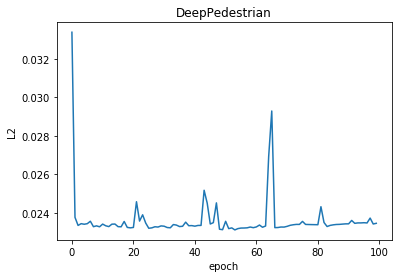

In [12]:
plt.plot(l3)
plt.xlabel('epoch')
plt.ylabel('L2')
plt.title('DeepPedestrian')
plt.savefig('C:/Users/horan/Desktop/FuseVis/Loss curves/DeepPedestrian/Loss curves/L2_loss.png', bbox_inches = 'tight',pad_inches = 0)

In [49]:
#load the test input MRI dataset
filenames = os.listdir('C:/Users/horan/Desktop/FuseVis/MRI/')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/FuseVis/MRI/')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
test_mri = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    test_mri[i,:,:] =(imageio.imread(data[i]))
    test_mri[i,:,:] =(test_mri[i,:,:] - np.min(test_mri[i,:,:])) / (np.max(test_mri[i,:,:]) - np.min(test_mri[i,:,:]))
    test_mri[i,:,:] = np.float32(test_mri[i,:,:])

In [50]:
#expand dimension to add the channel
test_mri = np.expand_dims(test_mri,axis=1)
#verify the shape matches the pytorch standard
test_mri.shape

(1, 1, 256, 256)

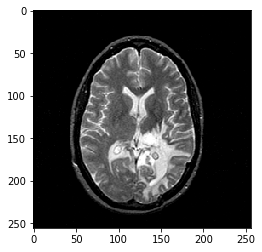

In [51]:
#verify the test mri image
#test_mri = test_mri[0,:,:,:]
#test_mri = np.expand_dims(test_mri,axis=0)
plt.imshow(test_mri[0,0,:,:],'gray')
#plt.savefig('MRI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [58]:
#convert the MRI Testing data to pytorch tensor
test_mri_tensor = torch.from_numpy(test_mri).float()
test_mri_tensor = test_mri_tensor.to(device)
print(test_mri_tensor.shape)
test_mri_tensor.requires_grad =True

torch.Size([1, 1, 256, 256])


In [59]:
#load the test input PET dataset
filenames = os.listdir('C:/Users/horan/Desktop/FuseVis/PET/')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/FuseVis/PET/')
data = glob.glob(os.path.join(dataset, "*.png"))
data = natsort.natsorted(data,reverse=False)
test_pet = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    test_pet[i,:,:] =(imageio.imread(data[i]))
    test_pet[i,:,:] =(test_pet[i,:,:] - np.min(test_pet[i,:,:])) / (np.max(test_pet[i,:,:]) - np.min(test_pet[i,:,:]))
    test_pet[i,:,:] = np.float32(test_pet[i,:,:])

In [60]:
#expand dimension to add the channel
test_pet = np.expand_dims(test_pet,axis=1)
#verify the shape matches the pytorch standard
test_pet.shape 

(1, 1, 256, 256)

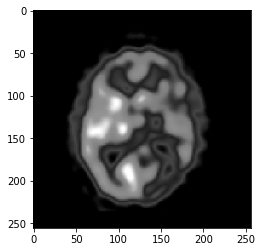

In [61]:
plt.imshow(test_pet[0,0,:,:],'gray')
#plt.savefig('PET.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [62]:
#convert the MRI Testing data to pytorch tensor
test_pet_tensor = torch.from_numpy(test_pet).float()
test_pet_tensor = test_pet_tensor.to(device)
print(test_pet_tensor.shape)
test_pet_tensor.requires_grad =True

torch.Size([1, 1, 256, 256])


In [63]:
#load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn =torch.load('C:/Users/horan/Desktop/FuseVis/.ipynb_checkpoints/DeepPedestrian/checkpoint.pth')
cnn.eval()

DeepPedestrian(
  (conv1): Sequential(
    (0): Conv2d(2, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): ReLU()
    (1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv3): Sequential(
    (0): ReLU()
    (1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(

In [64]:
#predicted the fused image
fused = cnn(test_mri_tensor.to(device), test_pet_tensor.to(device))
fused_numpy = fused.data.cpu().numpy()

In [65]:
fused.shape

torch.Size([1, 1, 256, 256])

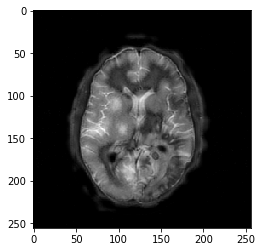

In [66]:
#verify the output image
plt.imshow(fused_numpy[0,0,:,:],'gray')
#plt.savefig('Fused.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [69]:
imageio.imwrite('C:/Users/horan/Desktop/FuseVis/Fused/DeepPedestrian/Fused.png',np.uint8(cv2.normalize(fused_numpy[0,0,:,:], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)))

In [70]:
#calculate the guidance image for MRI and PET wrt to the fused image
time1 = time.time()
count = 0 
guide_fuse_mri = np.zeros((256,256),dtype=float)
guide_fuse_pet = np.zeros((256,256),dtype=float)

for y_coord in range(0,256):
    for x_coord in range(0,256):
        jacob_fuse_mri = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_mri_tensor, retain_graph=True, create_graph=True)[0]
        jacob_numpy_mri = np.squeeze(jacob_fuse_mri.data.cpu().numpy())  
        guide_fuse_mri[y_coord,x_coord] = jacob_numpy_mri[y_coord,x_coord]
        jacob_fuse_pet = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_pet_tensor, retain_graph=True, create_graph=True)[0]
        jacob_numpy_pet = np.squeeze(jacob_fuse_pet.data.cpu().numpy())  
        guide_fuse_pet[y_coord,x_coord] = jacob_numpy_pet[y_coord,x_coord]
        count += 1
        if count % 1000 == 0:
            print('Count is %d' %count)
time2 = time.time()
print('Time taken to compute is %d seconds' %(time2-time1))

Count is 1000
Count is 2000
Count is 3000
Count is 4000
Count is 5000
Count is 6000
Count is 7000
Count is 8000
Count is 9000
Count is 10000
Count is 11000
Count is 12000
Count is 13000
Count is 14000
Count is 15000
Count is 16000
Count is 17000
Count is 18000
Count is 19000
Count is 20000
Count is 21000
Count is 22000
Count is 23000
Count is 24000
Count is 25000
Count is 26000
Count is 27000
Count is 28000
Count is 29000
Count is 30000
Count is 31000
Count is 32000
Count is 33000
Count is 34000
Count is 35000
Count is 36000
Count is 37000
Count is 38000
Count is 39000
Count is 40000
Count is 41000
Count is 42000
Count is 43000
Count is 44000
Count is 45000
Count is 46000
Count is 47000
Count is 48000
Count is 49000
Count is 50000
Count is 51000
Count is 52000
Count is 53000
Count is 54000
Count is 55000
Count is 56000
Count is 57000
Count is 58000
Count is 59000
Count is 60000
Count is 61000
Count is 62000
Count is 63000
Count is 64000
Count is 65000
Time taken to compute is 2683 seco

In [71]:
h5f = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/H5 Files/Jacobian_MRI.h5', 'w')
h5f.create_dataset('Jacob_MRI_dataset', data=guide_fuse_mri)
h5f.close()

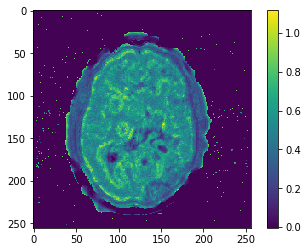

In [72]:
plt.imshow(guide_fuse_mri,cmap='viridis')
plt.colorbar()
plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Guide_Fused_MRI_DPI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [73]:
h5f = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/H5 Files/Jacobian_PET.h5', 'w')
h5f.create_dataset('Jacob_PET_dataset', data=guide_fuse_pet)
h5f.close()

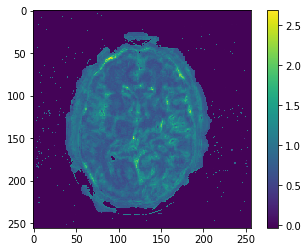

In [74]:
plt.imshow(guide_fuse_pet,cmap='viridis')
plt.colorbar()
plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Guide_Fused_PET_DPI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [75]:
#define overlay images
fused_RGB = np.zeros((256,256,3),dtype=float)
mri_RGB   = np.zeros((256,256,3),dtype=float)
pet_RGB   = np.zeros((256,256,3),dtype=float)

In [76]:
fused_RGB[:,:,0]  = guide_fuse_mri 
fused_RGB[:,:,1]  = guide_fuse_pet 
fused_RGB[:,:,2]  = fused_numpy[0,0,:,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


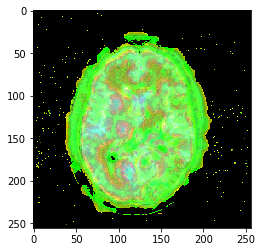

In [77]:
plt.imshow(fused_RGB)
plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Fused_RGB_DPI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [78]:
mri_RGB[:,:,0]  = guide_fuse_mri
mri_RGB[:,:,1]  = guide_fuse_pet 
mri_RGB[:,:,2]  = test_mri[0,0,:,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


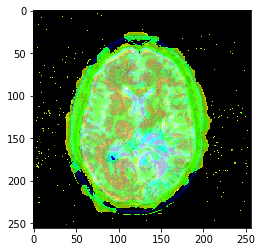

In [79]:
plt.imshow(mri_RGB)
plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/MRI_RGB_DPI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [80]:
pet_RGB[:,:,0]  = guide_fuse_mri
pet_RGB[:,:,1]  = guide_fuse_pet 
pet_RGB[:,:,2]  = test_pet[0,0,:,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


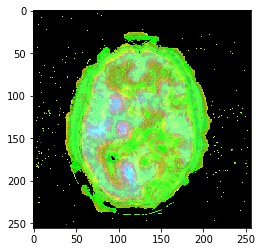

In [81]:
plt.imshow(pet_RGB)
plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/PET_RGB_DPI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [82]:
#define the window
root = Tk()  
root.title('Visualisation of fusion networks')
root.configure(background='white')


#Label the images
#fontStyle = tkFont.Font(family="Lucida Grande", size=15)
#w1 = tk.Label(root, bg='white', font=fontStyle, text="Fused Image")
#w1.grid(row=0, column=1)
#w1.pack()

#define the frame
canvasframe = Frame(root)  # define Input and output frame
buttonframe = Frame(root)  # define button frame
canvasframe.pack()  # pack the Input and Output frame
buttonframe.pack()  # pack the button frame


#define the canvas
canvas = Canvas(canvasframe, width=1800, height=920, bg = 'white')
canvas.grid(row=0, column=0)

#Insert fused image to the canvas
img_fused = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/Fused/DeepPedestrian/Fused.png") # load the image
canvas.create_image(0, 0, image=img_fused, anchor=NW)

#Insert MRI image to the canvas
img_mri = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/MRI/MRI.gif") # load the image
canvas.create_image(600, 0, image=img_mri, anchor=NW)

#Insert PET image to the canvas
img_pet = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/PET/3.png") # load the image
canvas.create_image(1200, 0, image=img_pet, anchor=NW)

def start_mouseover():  # function called when user clicks the button 
    # link the function to the left-mouse-click event
    canvas.bind("<B1-Motion>", Coordinates)

def Coordinates(event): # function called when left-mouse-button is clicked with a mouseover
    x_coord = event.x  # save x and y coordinates selected by the user   
    y_coord = event.y
    print('mouse position is at' + '(' + str(y_coord) + ',' + str(x_coord) + ')', end='\r')
    #display the output MRI Jacobian image
    #img_MR_out = ImageTk.PhotoImage(file ='C:/Users/cgvadmin/Desktop/FuseVis/Fused_MRI/im_' + str(y_coord) + '_' + str(x_coord) + '.png') # load the image
    jacobian_fuse_mri = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_mri_tensor, retain_graph=True, create_graph=True)[0]
    jacobian_fuse_pet = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_pet_tensor, retain_graph=True, create_graph=True)[0]
    
    jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
    jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
    
    x_mri = np.asarray(np.where(np.any(jacob_val_mri, axis = 0)))
    y_mri = np.asarray(np.where(np.any(jacob_val_mri, axis = 1)))
    minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
    zoom_im_mri = jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri] 
    
    x_pet = np.asarray(np.where(np.any(jacob_val_pet, axis = 0)))
    y_pet = np.asarray(np.where(np.any(jacob_val_pet, axis = 1)))
    minx_pet, maxx_pet, miny_pet, maxy_pet = np.min(x_pet), np.max(x_pet), np.min(y_pet), np.max(y_pet)  #return min and max coordinates
    zoom_im_pet = jacob_val_pet[miny_pet:maxy_pet,minx_pet:maxx_pet] 
    
    plt.imshow(fused_numpy[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri], cmap = 'gray', aspect ='equal')
    plt.title('Zoom Fused')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Zoom_Fused.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out11 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Zoom_Fused.png')
    canvas.create_image(300,5,image=im_out11,anchor=NW)
    canvas.image11 = im_out11
    plt.tight_layout()
    
    plt.imshow(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri], cmap = 'gray', aspect ='equal')
    plt.title('Zoom MRI')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Zoom_MRI.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out12 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Zoom_MRI.png')
    canvas.create_image(900,5,image=im_out12,anchor=NW)
    canvas.image12 = im_out12
    plt.tight_layout()
    
    plt.imshow(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri], cmap = 'gray', aspect ='equal')
    plt.title('Zoom PET')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Zoom_PET.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out13 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Zoom_PET.png')
    canvas.create_image(1500,5,image=im_out13,anchor=NW)
    canvas.image13 = im_out13
    plt.tight_layout()
    
    plt.imshow(jacob_val_mri,cmap='viridis', aspect ='equal')
    plt.title('Jacobian (Fused wrt MRI)')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Jacob_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out1 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Jacob_Fused_MRI.png')
    canvas.create_image(40,320,image=im_out1,anchor=NW)
    canvas.image1 = im_out1
    #plt.tight_layout()
    
    #f.add_subplot(1,5,2)
    plt.imshow(zoom_im_mri,cmap='viridis',aspect ='equal')
    plt.title('Zoom Jacobian (Fused wrt MRI)')
    plt.colorbar()
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Zoom_Jacob_MRI.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out2 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Zoom_Jacob_MRI.png')
    canvas.create_image(380,320,image=im_out2,anchor=NW)
    canvas.image2 = im_out2
    
    #f.add_subplot(1,5,3)
    plt.xlim(0,0.7)
    plt.ylim(0,0.7)
    plt.plot(jacob_val_mri[y_coord,x_coord],jacob_val_pet[y_coord,x_coord],'-ro')
    plt.xlabel('MRI pixel score (Fused wrt MRI)')
    plt.ylabel('PET pixel score (Fused wrt PET)')
    plt.title('Mouse position at: (' + str(y_coord) + ',' + str(x_coord) + ')')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Pixel_intensities.png', bbox_inches = 'tight',pad_inches = 0.1)
    plt.close()
    im_out3 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Pixel_intensities.png')
    canvas.create_image(750,320,image=im_out3,anchor=NW)
    canvas.image3 = im_out3
    
    #f.add_subplot(1,5,4)
    plt.imshow(jacob_val_pet,cmap='viridis',aspect ='equal')
    plt.title('Jacobian (Fused wrt PET)')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Jacob_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out4 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Jacob_Fused_PET.png')
    canvas.create_image(1110,320,image=im_out4,anchor=NW)
    canvas.image4 = im_out4
    #plt.tight_layout()
    
    #f.add_subplot(1,5,5)
    plt.imshow(zoom_im_pet,cmap='viridis',aspect ='equal')
    plt.title('Zoomed Jacobian (Fused wrt PET)')
    plt.colorbar()
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Zoom_Jacob_PET.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out5 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Zoom_Jacob_PET.png')
    canvas.create_image(1450,320,image=im_out5,anchor=NW)
    canvas.image5 = im_out5

    plt.imshow(guide_fuse_mri,cmap='viridis')
    plt.title('Guidance (Fused wrt MRI)')
    plt.colorbar()
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Guide_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out6 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Guide_Fused_MRI.png')
    canvas.create_image(100,650,image=im_out6,anchor=NW)
    canvas.image6 = im_out6
    
    plt.imshow(fused_RGB)
    plt.title('R=I1 G=I2 B=Fused')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Fused_RGB.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out8 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Fused_RGB.png')
    canvas.create_image(420,650,image=im_out8,anchor=NW)
    canvas.image8 = im_out8
    
    plt.imshow(mri_RGB)
    plt.title('R=I1 G=I2 B=MRI')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/MRI_RGB.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out9 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/MRI_RGB.png')
    canvas.create_image(740,650,image=im_out9,anchor=NW)
    canvas.image9 = im_out9
    
    plt.imshow(pet_RGB)
    plt.title('R=I1 G=I2 B=PET')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/PET_RGB.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out10 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/PET_RGB.png')
    canvas.create_image(1100,650,image=im_out10,anchor=NW)
    canvas.image10 = im_out10
    
    plt.imshow(guide_fuse_pet,cmap='viridis')
    plt.title('Guidance (Fused wrt PET)')
    plt.colorbar()
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Guide_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out7 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Guide_Fused_PET.png')
    canvas.create_image(1400,650,image=im_out7,anchor=NW)
    canvas.image7 = im_out7
    
    radius = 5
    i = canvas.create_oval(x_coord-radius, y_coord-radius, x_coord+radius, y_coord+radius, fill = 'red')
    canvas.after(20,canvas.delete,i)

# insert button to the middleframe and link it to "Start Mouseover"
button_start_mouseover = Button(buttonframe, text="Start Mouseover",command=start_mouseover)
button_start_mouseover.grid(row=1, column=0, pady=0)


root.mainloop()  #keep the GUI open

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
